In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from scipy import stats
from scipy.stats import wasserstein_distance

In [3]:
def get_pandas_dict(dirpath):
    # Getting filelist:
    file_list = os.listdir(dirpath)
    pandas_dict = {}

    # Iterating through list:
    for filename in file_list:
        filepath = os.path.join(dirpath, filename)
        if os.path.isdir(filepath):
            continue
        if ".txt" not in filepath:
            continue
        pandas_dict[filename.split(".")[0]] = pd.read_csv(filepath, header=2, sep="\t")

    return pandas_dict

In [4]:
pd_dict = get_pandas_dict("TB Mon Analysis/Input Feature Files")

In [5]:
keys = list(pd_dict.keys())
keys.sort()
keys

['K490ACTL1_0',
 'K490ACTL2_0',
 'K490ACTL3_0',
 'K490AMON1_0',
 'K490AMON2_0',
 'K490AMON3_0',
 'K490ATB1_0',
 'K490ATB2_0',
 'K490ATB3_0',
 'WTCTL1_0',
 'WTCTL2_0',
 'WTCTL3_0',
 'WTMON1_0',
 'WTMON2_0',
 'WTMON3_0',
 'WTTB1_0',
 'WTTB2_0',
 'WTTB3_0']

In [6]:
features = list(pd_dict["WTTB1_0"])
features.sort()

In [7]:
included_ch = ["01", "02", "06", "11", "Cytoplasm", "Perimembrane"] 
lda_feature_list = [feature for feature in features if any(ch in feature for ch in included_ch)]
excluded_features = [feature for feature in features if not any(ch in feature for ch in included_ch)]

In [11]:
# Getting numpy array of features:
condition_list = ["WTCTL", "WTTB", "WTMON", "K490ACTL", "K490ATB", "K490AMON"]
condition_label_dict = {
    "WTCTL": 0, "WTTB": 1, "WTMON": 2,
    "K490ACTL": 3, "K490ATB": 4, "K490AMON": 5
}
label_array = []
data_array = []
collapse_indices = [0]
for condition in condition_list:
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        data = pd_dict[label][lda_feature_list]
        arr = np.asarray(data)
        print(arr.shape)
        
        # Appending data and labels:
        label = condition_label_dict[condition]
        temp_label_arr = np.full(arr.shape[0], label)
        label_array.append(temp_label_arr)
        data_array.append(arr)
        
        collapse_indices.append(arr.shape[0] + collapse_indices[-1])

label_array = np.concatenate(label_array, axis=0)
data_array = np.concatenate(data_array, axis=0)

(7105, 132)
(6712, 132)
(7058, 132)
(6043, 132)
(7522, 132)
(7555, 132)
(7196, 132)
(6509, 132)
(6873, 132)
(6353, 132)
(6859, 132)
(5867, 132)
(7903, 132)
(7641, 132)
(5771, 132)
(7332, 132)
(7063, 132)
(6532, 132)


In [9]:
# Preallocating normalised array:
normed_array = np.zeros_like(data_array)

# Finding features that are non-negative and log scaling:
features_to_log = ~np.any(data_array <= 0, axis=0)
normed_array[:, features_to_log] = np.log(data_array[:, features_to_log])
normed_array[:, ~features_to_log] = data_array[:, ~features_to_log]

# Performing z-score normalisation data prior to random forest feature importance scoring:
means = np.mean(normed_array, axis=0, keepdims=True)
std = np.std(normed_array, axis=0, keepdims=True)

# Removing zero-variance features (these will be things like saturation count):
std_mask = np.squeeze(std > 0)

normed_array = (normed_array[:, std_mask] - means[:, std_mask]) / std[:, std_mask]

In [10]:
normed_array.shape

(123894, 126)

## 1 Performing LDA

In [19]:
# Performing LDA and transforming along most discriminable direction:
lda_clf = LinearDiscriminantAnalysis(n_components=2)
lda_embeddings = lda_clf.fit_transform(normed_array, label_array)

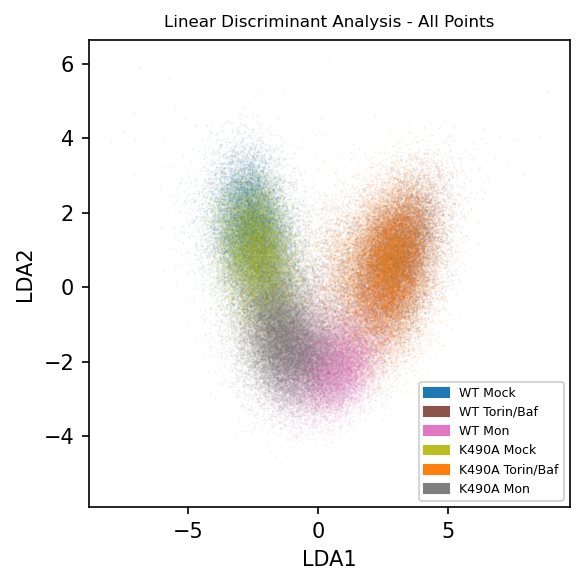

In [48]:
# Plotting first two components of LDA dimension reduction:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT Mock", "WT Torin/Baf", "WT Mon", "K490A Mock", "K490A Torin/Baf", "K490A Mon"]
col_labels = np.array(['tab:blue', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:gray'])

count = 0
for cond_num in range(6):
    cond_arr = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        cond_arr.append(arr)
    cond_arr = np.concatenate(cond_arr, axis=0)
    ax.scatter(
        x=cond_arr[:, 0], y=cond_arr[:, 1], s=3, marker=".", alpha=0.1,
        c=col_labels[cond_num], label=str_labels[cond_num], linewidths=0
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(6)]
ax.legend(colour_patches, str_labels, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - All Points", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="TB Mon Analysis/Output Figures/Linear Discriminant Analysis - All Points.png", format="png")

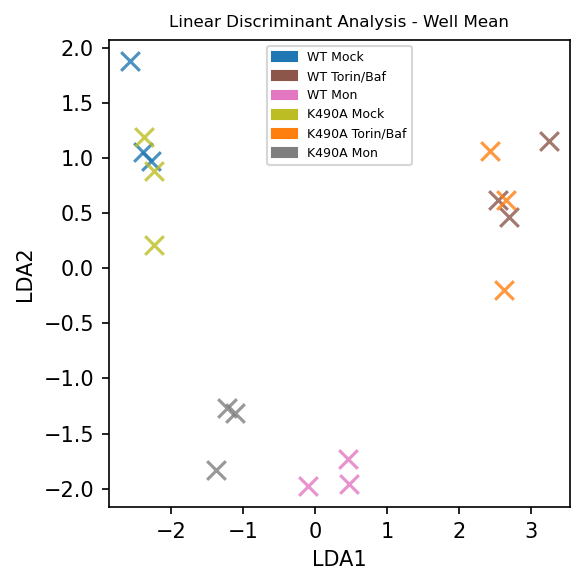

In [21]:
# Generating well averages plot:
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

str_labels = ["WT Mock", "WT Torin/Baf", "WT Mon", "K490A Mock", "K490A Torin/Baf", "K490A Mon"]
col_labels = np.array(['tab:blue', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:gray'])

count = 0
for cond_num in range(6):
    cond_averages = []
    for idx in range(3):
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        arr = lda_embeddings[start_idx:end_idx, :]
        well_average = np.mean(arr, axis=0)
        cond_averages.append(well_average)
    cond_averages = np.stack(cond_averages, axis=0)
    ax.scatter(
        x=cond_averages[:, 0], y=cond_averages[:, 1], s=80, marker="x", alpha=0.8,
        c=col_labels[cond_num], label=str_labels[cond_num]
    )

# Plotting legend and assigning colours:
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(6)]
ax.legend(colour_patches, str_labels, prop={'size': 6}, loc=9)

# Titling figure:
plt.title(label="Linear Discriminant Analysis - Well Mean", fontsize=8);
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')

# Saving figure:
plt.tight_layout()
plt.savefig(fname="TB Mon Analysis/Output Figures/Linear Discriminant Analysis - Well Mean.png", format="png")

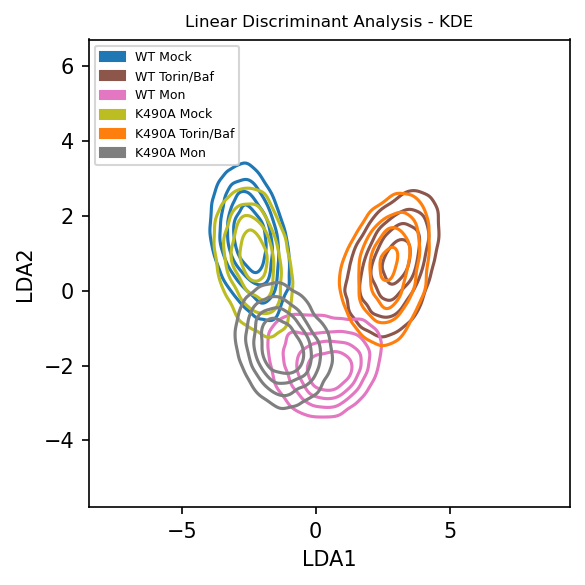

In [22]:
# Formatting data:
plot_dataset = [
    pd.DataFrame(lda_embeddings[label_array == 0, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 1, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 2, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 3, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 4, :], columns=["LDA1", "LDA2"]),
    pd.DataFrame(lda_embeddings[label_array == 5, :], columns=["LDA1", "LDA2"]),
]

# Formatting data:
str_labels = ["WT Mock", "WT Torin/Baf", "WT Mon", "K490A Mock", "K490A Torin/Baf", "K490A Mon"]
plot_dataset = pd.concat(plot_dataset, keys=str_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['tab:blue', 'tab:brown', 'tab:pink', 'tab:olive', 'tab:orange', 'tab:gray']
fig, ax = plt.subplots(figsize=(4, 4), dpi=150)

# Plotting and labelling:
sns.kdeplot(
    data=plot_dataset, x="LDA1", y="LDA2", hue="Condition",
    ax=ax, palette=col_labels, levels=5, thresh=.2,
)

colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(6)]
ax.legend(colour_patches, str_labels, loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="Linear Discriminant Analysis - KDE", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="TB Mon Analysis/Output Figures/Linear Discriminant Analysis - KDE.png", format="png")

## 2 Performing Wasserstein distance distribution comparisons

In [28]:
def get_embedding_arrays(embeddings):
    count = 0
    condition_dict = {}
    for condition in range(6):
        condition_arrays = []
        for repeat in range(3):
            # Selecting data:
            start_idx = collapse_indices[count]
            end_idx = collapse_indices[count+1]
            count += 1
            cr_embeddings = embeddings[start_idx:end_idx, :]
            condition_arrays.append(cr_embeddings)
        condition_dict[condition] = condition_arrays
    return condition_dict

def calculate_distance(embeddings_a, embeddings_b):
    distance_dim1 = wasserstein_distance(embeddings_a[:, 0], embeddings_b[:, 0])
    distance_dim2 = wasserstein_distance(embeddings_a[:, 1], embeddings_b[:, 1])
    return distance_dim1 + distance_dim2
    

def calculate_diff_distance(condition_dict, cond_1, cond_2):
    # Calculating distances within conditions:
    arrlist_condA = condition_dict[cond_1]
    arrlist_condB = condition_dict[cond_2]
    
    A_distances = []
    B_distances = []
    for i in range(3):
        # Calculating for cond A:
        dist_A = calculate_distance(arrlist_condA[i], arrlist_condA[(i+1)%3])
        A_distances.append(dist_A)        

        # Calculating for cond B:
        dist_B = calculate_distance(arrlist_condB[i], arrlist_condB[(i+1)%3])
        B_distances.append(dist_B)
        

    # Calculating distance between conditions:
    full_arr_A = np.concatenate(arrlist_condA, axis=0)
    full_arr_B = np.concatenate(arrlist_condB, axis=0)
    full_distance = calculate_distance(full_arr_A, full_arr_B)
    
    print(A_distances)
    print(np.mean(A_distances))
    print(B_distances)
    print(np.mean(B_distances))
    print(full_distance)

In [33]:
# WTCTL vs. K490ACTL:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 0, 3)

[1.0123298643473861, 0.20322722965340537, 1.215183723381653]
0.8102469391274815
[0.448944798290274, 0.6901598405567001, 1.1204615757267662]
0.7531887381912469
0.6614915277331082


In [34]:
# WTTB vs. K490ATB:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 1, 4)

[1.2381600750998834, 0.3162726383549239, 1.2427242503090423]
0.9323856545879498
[0.6804171265324657, 0.8676387138616579, 1.4605316191801176]
1.002862486524747
0.3927601065069793


In [35]:
# WTMON vs K490AMON:
cond_dict = get_embedding_arrays(lda_embeddings)
calculate_diff_distance(cond_dict, 2, 5)

[0.7933179854246644, 0.5937016484758602, 0.2631128650082287]
0.5500441663029177
[0.15901739336006365, 0.7170434587531513, 0.7928621304166305]
0.5563076608432818
1.9469893208423263


## 3 LDA - singular class phenotype investigation

In [53]:
# Retrieving coefficients that drive distinction of WTMON:
wtmon_coefs = lda_clf.coef_[2, :].flatten()
wtmon_decision_values = np.sum(normed_array * wtmon_coefs, axis=1)

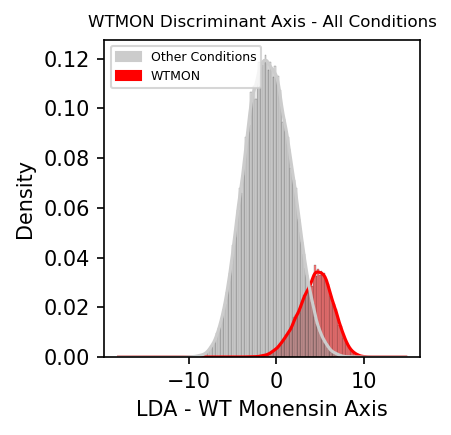

In [54]:
# Formatting data:
plot_dataset = [
    pd.Series(wtmon_decision_values[label_array == 0].flatten(), name="LDA - WT Monensin Axis"),
    pd.Series(wtmon_decision_values[label_array == 1].flatten(), name="LDA - WT Monensin Axis"),
    pd.Series(wtmon_decision_values[label_array == 2].flatten(), name="LDA - WT Monensin Axis"),
    pd.Series(wtmon_decision_values[label_array == 3].flatten(), name="LDA - WT Monensin Axis"),
    pd.Series(wtmon_decision_values[label_array == 4].flatten(), name="LDA - WT Monensin Axis"),
    pd.Series(wtmon_decision_values[label_array == 5].flatten(), name="LDA - WT Monensin Axis"),
]

# Formatting data:
key_labels = ["Other Conditions"] * 6
key_labels[2] = "WTMON"
plot_dataset = pd.concat(plot_dataset, keys=key_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['0.8', 'r']
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    x="LDA - WT Monensin Axis", stat="density", hue="Condition",
    data=plot_dataset, ax=ax, palette=col_labels, kde=True
)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(2)]
ax.legend(colour_patches, ["Other Conditions", "WTMON"], loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="WTMON Discriminant Axis - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="TB Mon Analysis/Output Figures/WTMON Discriminant Axis - All Conditions.png", format="png")

In [52]:
# Exporting mean LDA-WT Monensin Axis values for plotting in PRISM:
count = 0
output_list = []
for condition in range(6):
    repeat_means = []
    for repeat in range(3):
        # Selecting data:
        start_idx = collapse_indices[count]
        end_idx = collapse_indices[count+1]
        count += 1
        feature_values = wtmon_decision_values[start_idx:end_idx]
        repeat_means.append(np.mean(feature_values))
    output_list.append(repeat_means)

output_list

[[-3.257209238129384, -2.4638802126410173, -2.4932981754949517],
 [-1.9983950126477725, -0.359698697919118, -0.25867439018164995],
 [4.313551858986312, 4.807949592712221, 4.371076908082769],
 [-2.8908939199308405, -2.5619433235123954, -1.2470029865510897],
 [-1.3367088936020495, -0.4878241345743987, 1.3925922671788524],
 [1.1420650008239004, 1.0922636641450725, 2.3051484686670864]]

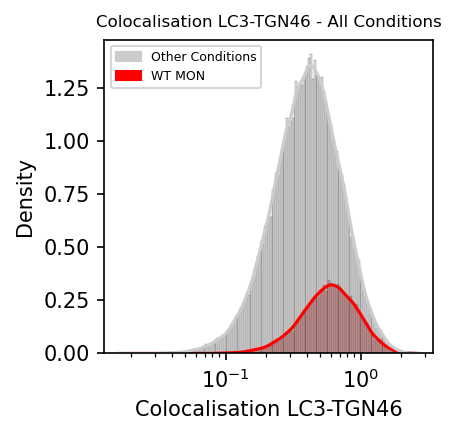

In [49]:
# Retrieving Bright Detail Similarity values:
bds_values = data_array[:, np.array(lda_feature_list) == "Bright Detail Similarity R3_M01_Ch01_Ch01"]

# Formatting data:
plot_dataset = [
    pd.Series(bds_values[label_array == 0].flatten(), name="Colocalisation LC3-TGN46"),
    pd.Series(bds_values[label_array == 1].flatten(), name="Colocalisation LC3-TGN46"),
    pd.Series(bds_values[label_array == 2].flatten(), name="Colocalisation LC3-TGN46"),
    pd.Series(bds_values[label_array == 3].flatten(), name="Colocalisation LC3-TGN46"),
    pd.Series(bds_values[label_array == 4].flatten(), name="Colocalisation LC3-TGN46"),
    pd.Series(bds_values[label_array == 5].flatten(), name="Colocalisation LC3-TGN46"),
]

# Formatting data:
key_labels = ["Other Conditions"] * 6
key_labels[2] = "WTMON"
plot_dataset = pd.concat(plot_dataset, keys=key_labels, names=["Condition", "Row ID"]).reset_index()

# Setting up figure:
col_labels = ['0.8', 'r']
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)

# Plotting and labelling:
sns.histplot(
    x="Colocalisation LC3-TGN46", stat="density", hue="Condition",
    data=plot_dataset, ax=ax, palette=col_labels, kde=True, log_scale=True
)
colour_patches = [mpatches.Patch(color=col_labels[i]) for i in range(2)]
ax.legend(colour_patches, ["Other Conditions", "WT MON"], loc=2, prop={'size': 6})

# Titling figure:
plt.title(label="Colocalisation LC3-TGN46 - All Conditions", fontsize=8);

# Saving figure:
plt.tight_layout()
plt.savefig(fname="TB Mon Analysis/Output Figures/LC3-TGN46 Bright Detail Similarity - All Conditions.png", format="png")

## 4 Exporting population files for visualisation

In [45]:
# Generating .pop files for use in IDEAS

# WTMON1
idx = 6

start_idx = collapse_indices[idx]
end_idx = collapse_indices[idx+1]
arr = wtmon_decision_values[start_idx:end_idx]
upper_mask = arr > 6
lower_mask = arr < 1
identifiable_obj_list = list(pd_dict["WTMON1_0"]["Object Number"][upper_mask])
noise_obj_list = list(pd_dict["WTMON1_0"]["Object Number"][lower_mask])

full_text = ""
for obj in identifiable_obj_list:
    full_text = full_text + f"{obj},\n"
with open("wtmon1_id.pop", "w") as fout:
    fout.write(full_text)

full_text = ""
for obj in noise_obj_list:
    full_text = full_text + f"{obj},\n"
with open("wtmon1_noise.pop", "w") as fout:
    fout.write(full_text)

In [539]:
# Getting mean values for LC3 intensity difference:
idx_list = [6, 7, 8]
cond_list = ["WTMON1_0", "WTMON2_0", "WTMON3_0"]

id_list = []
noise_list = []
for idx, cond in zip(idx_list, cond_list):
    start_idx = collapse_indices[idx]
    end_idx = collapse_indices[idx+1]
    arr = wtmon_decision_values[start_idx:end_idx]
    upper_mask = arr > 6
    lower_mask = arr < 1
    id_intensity = np.array(list(pd_dict[cond]["Intensity_MC_Ch02"][upper_mask]))
    noise_intensity = np.array(list(pd_dict[cond]["Intensity_MC_Ch02"][lower_mask]))
    
    id_list.append(np.mean(id_intensity))
    noise_list.append(np.mean(noise_intensity))

print(noise_list)
print(id_list)

[475363.5868043233, 472683.12879946886, 445494.9347377443]
[527107.0683404601, 518599.5891059504, 491618.0309989046]


In [540]:
# Getting mean values for TGN46 intensity difference:
idx_list = [6, 7, 8]
cond_list = ["WTMON1_0", "WTMON2_0", "WTMON3_0"]

id_list = []
noise_list = []
for idx, cond in zip(idx_list, cond_list):
    start_idx = collapse_indices[idx]
    end_idx = collapse_indices[idx+1]
    arr = wtmon_decision_values[start_idx:end_idx]
    upper_mask = arr > 6
    lower_mask = arr < 1
    id_intensity = np.array(list(pd_dict[cond]["Intensity_MC_Ch11"][upper_mask]))
    noise_intensity = np.array(list(pd_dict[cond]["Intensity_MC_Ch11"][lower_mask]))
    
    id_list.append(np.mean(id_intensity))
    noise_list.append(np.mean(noise_intensity))

print(noise_list)
print(id_list)

[759409.2596219585, 765668.9915137541, 687951.472610547]
[808874.0919577051, 785694.5155300422, 728196.4763860203]


## 2 Extracting mean values for plotting in PRISM

In [79]:
def generate_mean_values(pandas_dict, condition, feature_value, log=False):
    mean_list = []
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        data = pandas_dict[label][feature_value]
        if log:
            data = np.log(data[data>0])
        mean = np.median(np.asarray(data))
        mean_list.append(mean)
    return mean_list

In [ ]:
feature = 'Bright Detail Similarity R3_M01_Ch01_Ch01'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "K490ACTL", feature))

print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))

print(generate_mean_values(pd_dict, "WTMON", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[0.362778071369458, 0.368377701380613, 0.3381655344750585]
[0.36635710375477, 0.343688710270954, 0.359509903331909]
[0.403077056288636, 0.413223791750373, 0.413666121991071]
[0.401760820874486, 0.40308731105189, 0.409607161588665]
[0.5892468607634296, 0.590140316278233, 0.595424801541151]
[0.500240149669138, 0.495015228065856, 0.5103071028998569]


In [550]:
feature = 'Compactness_M11_Ch11'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "K490ACTL", feature))

print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))

print(generate_mean_values(pd_dict, "WTMON", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[0.717126688828063, 0.7307791369682946, 0.7137361624696235]
[0.720092231142957, 0.709629257241939, 0.708860359312077]
[0.774541915950295, 0.766043352908695, 0.760342986967747]
[0.760345261882286, 0.754374010823071, 0.755356303847376]
[0.8132540177585605, 0.817626015856525, 0.810718278941458]
[0.8209725004738375, 0.820750381802654, 0.814947592468711]


In [559]:
feature = 'H Variance Mean_M11_Ch11_5'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "K490ACTL", feature))

print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))

print(generate_mean_values(pd_dict, "WTMON", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[5.01328040904314, 5.052920004383685, 4.849328470364121]
[5.07510183275977, 4.88965943193348, 5.12982044851495]
[6.04290896903557, 5.882407487543145, 5.91604477165483]
[6.06337045804299, 6.00883852189451, 5.97610322206785]
[8.58095284479148, 8.44313027170584, 8.61867636467768]
[8.998397752416789, 9.0538448817544, 9.006273516481725]


In [84]:
feature = 'Centroid X Intensity_M02_Ch02'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "WTMON", feature))

print(generate_mean_values(pd_dict, "K490ACTL", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[14.5186439273018, 14.7843753285368, 14.56195082694575]
[14.2041324628293, 14.889258898633699, 14.8599603953769]
[14.76542924084175, 14.9532230407383, 14.7518999030888]
[14.5448309214706, 14.5484186461054, 14.4631036015802]
[14.4535717793339, 14.5124129785049, 15.0055962692551]
[14.7580178303623, 14.8041221922361, 14.53390295559555]


In [66]:
feature = 'Centroid Y Intensity_M02_Ch02'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "WTMON", feature))

print(generate_mean_values(pd_dict, "K490ACTL", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[14.8123896863347, 14.7971928866545, 14.685942703839551]
[14.97022976309635, 14.7877830546593, 14.7700877344638]
[14.62761624227945, 14.5845879694742, 14.61045184369135]
[14.67165370348345, 14.8108932105822, 14.689106907750201]
[14.7495494249255, 14.8088221228364, 14.720214718051949]
[14.6684128829343, 14.6663381066109, 14.548116458851]


In [67]:
feature = 'Angle Intensity_M02_Ch02'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "WTMON", feature))

print(generate_mean_values(pd_dict, "K490ACTL", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[0.962600718033309, 0.957438368706665, 0.922140459442329]
[0.8367477329565249, 0.8579683907421025, 0.8624624950288231]
[0.8661049845903626, 0.8789300178536175, 0.872883922449801]
[0.9748727692241366, 0.952192403937309, 1.002652865970725]
[0.841940475374666, 0.86258827763091, 0.865231820154811]
[0.920678192658799, 0.881741699994394, 0.933305675415708]


In [70]:
feature = 'Bright Detail Intensity R7_M11_Ch11'

print(generate_mean_values(pd_dict, "WTCTL", feature))
print(generate_mean_values(pd_dict, "WTTB", feature))
print(generate_mean_values(pd_dict, "WTMON", feature))

print(generate_mean_values(pd_dict, "K490ACTL", feature))
print(generate_mean_values(pd_dict, "K490ATB", feature))
print(generate_mean_values(pd_dict, "K490AMON", feature))

[91167.9951171875, 86574.99856567386, 83819.99646377566]
[72560.49977111815, 71086.49629592896, 75171.00372314456]
[59872.99991226195, 55554.49609375, 55943.506759643555]
[78917.5000305176, 87930.9910430908, 82696.49983215329]
[73968.9945068359, 74797.4990158081, 74637.00312042239]
[54781.4997444153, 52177.4995727539, 54204.0000839233]


In [230]:
def generate_multiplied_values(pandas_dict, condition, feature_value_1, feature_value_2, log=False):
    mean_list = []
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        arr_1 = np.asarray(pandas_dict[label][feature_value_1])
        arr_2 = np.asarray(pandas_dict[label][feature_value_2])
        data = arr_1 * arr_2
        if log:
            data = np.log(data[data>0])
        mean = np.asarray(data).mean()
        mean_list.append(mean)
    return mean_list

In [45]:
feature1 = 'Gradient Max_M02_Ch02'
feature2 = 'Intensity_MC_Ch02'

print(generate_multiplied_values(pd_dict, "WTCTL", feature1, feature2))
print(generate_multiplied_values(pd_dict, "WTTB", feature1, feature2))
print(generate_multiplied_values(pd_dict, "WTMON", feature1, feature2))

print(generate_multiplied_values(pd_dict, "K490ACTL", feature1, feature2))
print(generate_multiplied_values(pd_dict, "K490ATB", feature1, feature2))
print(generate_multiplied_values(pd_dict, "K490AMON", feature1, feature2))

[17688157.587635312, 18240111.91472628, 16976682.67543767]
[34829694.03374355, 35459307.340598434, 35907454.92578344]
[21009510.929831352, 20140853.357071545, 20441340.642877344]
[16968956.062976383, 17732906.134880282, 16183499.046201704]
[34526620.18124869, 36320383.208293386, 35983978.21421581]
[19329463.63768343, 18530939.655644674, 18030811.5873477]


In [232]:
def generate_divided_values(pandas_dict, condition, numerator, denominator, log=False):
    mean_list = []
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        arr_1 = np.asarray(pandas_dict[label][numerator])
        arr_2 = np.asarray(pandas_dict[label][denominator])
        data = arr_1 / arr_2
        if log:
            data = np.log(data[data>0])
        mean = np.asarray(data).mean()
        mean_list.append(mean)
    return mean_list

In [234]:
def generate_subtracted_values(pandas_dict, condition, numerator, denominator, log=False):
    mean_list = []
    for i in range(3):
        label = condition + str(i + 1) + "_0"
        arr_1 = np.asarray(pandas_dict[label][numerator])
        arr_2 = np.asarray(pandas_dict[label][denominator])
        data = arr_1 - arr_2
        if log:
            data = np.log(data[data>0])
        mean = np.asarray(data).mean()
        mean_list.append(mean)
    return mean_list

In [235]:
feature1 = 'Contrast_M02_Ch02'
feature2 = 'H Contrast Mean_M02_Ch02_5'

print(generate_subtracted_values(pd_dict, "WTCTL", feature1, feature2))
print(generate_subtracted_values(pd_dict, "WTTB", feature1, feature2))
print(generate_subtracted_values(pd_dict, "WTMON", feature1, feature2))

print(generate_subtracted_values(pd_dict, "K490ACTL", feature1, feature2))
print(generate_subtracted_values(pd_dict, "K490ATB", feature1, feature2))
print(generate_subtracted_values(pd_dict, "K490AMON", feature1, feature2))

[16.03767039591878, 14.873931268517168, 15.576620829841149]
[12.606282231472692, 14.259093357891686, 14.970299650083657]
[8.851639818720198, 8.296827698759419, 9.584591089707097]
[13.548924690662595, 17.092171101234715, 19.51533328938066]
[13.688093699334583, 14.252454814400776, 14.156632866983525]
[18.934938409935246, 19.282477164585423, 19.90039902394944]


In [238]:
feature1 = 'Gradient RMS_M02_Ch02'
feature2 = 'H Homogeneity Mean_M02_Ch02_5'

print(generate_subtracted_values(pd_dict, "WTCTL", feature1, feature2))
print(generate_subtracted_values(pd_dict, "WTTB", feature1, feature2))
print(generate_subtracted_values(pd_dict, "WTMON", feature1, feature2))

print(generate_subtracted_values(pd_dict, "K490ACTL", feature1, feature2))
print(generate_subtracted_values(pd_dict, "K490ATB", feature1, feature2))
print(generate_subtracted_values(pd_dict, "K490AMON", feature1, feature2))

[0.7855128456685528, 0.13850350786867952, 0.3019402172604695]
[5.896325554362803, 6.574502066651997, 6.5689652712700815]
[2.8036549275468543, 1.864108327756697, 3.0905645453570307]
[-0.2199128829936407, 0.9837022762035977, 1.4068991978005065]
[6.193485748804272, 6.53208334292667, 6.525524719741384]
[2.9918343274732675, 3.072493807576405, 3.1667507354899525]


In [ ]:
feature1 = 'Gradient RMS_M02_Ch02'
feature2 = 'Mean Pixel_M02_Ch02'

print(generate_divided_values(pd_dict, "WTCTL", feature1, feature2))
print(generate_divided_values(pd_dict, "WTTB", feature1, feature2))
print(generate_divided_values(pd_dict, "WTMON", feature1, feature2))

print(generate_divided_values(pd_dict, "K490ACTL", feature1, feature2))
print(generate_divided_values(pd_dict, "K490ATB", feature1, feature2))
print(generate_divided_values(pd_dict, "K490AMON", feature1, feature2))

In [58]:
def generate_violinplot(pandas_dict, feature_value, log=True):
    arr_list = []
    ax_labels = []
    condition_list = ["WTCTL", "WTTB", "WTMON", "K490ACTL", "K490ATB", "K490AMON"]
    for condition in condition_list:
        for i in range(3):
            label = condition + str(i + 1) + "_0"
            ax_labels.append(condition + str(i + 1))
            data = pandas_dict[label][feature_value]
            if log:
                data = np.log(data[data>0])
            arr = np.asarray(data)
            arr_list.append(arr)

    # Generate dataframe:
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.stripplot(ax=ax, data=arr_list)
    ax.set(xticklabels=ax_labels)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
    return None